# Exercise 7: Clustering

In this assignment you will experiment with k-means as an image compression algorithm.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. 
5. Your code must run without errors. Code that cannot run will also earn you the grade of 0.
6. Write your own code. Cheating will not be tolerated. 
8. Submission includes the this notebook only. Answers to qualitative questions should be written in markdown cells (with $\LaTeX$ support).

## Part 1: color image quantization

Color image quantization is the process of transforming an image so that it can be represented with a small subset of colors; a subset smaller than the image's original palette size. Image quantization is a form of lossy data compression since the number of bits used for the palette is reduced. During this compression some data is lost and therefore we must use a careful algorithm that will minimize the perceived difference between the original image and its quantized counterpart. Other than compression, image quantization plays an important role in image recognition algorithms.

When representing images in true color, each pixel is represented by 3 RGB components and each one of the 3 RGB components is represented by 8 bits and can take a value from 0 to 255. This means that in true color representation one can use 2^24≈16 Million different colors. In this exercise we will perform image quantization from images given in true color into 256, 16 or even less colors.

There are many algorithms for quantization. In this exercise, you are going to use K-means in color space to achieve quantization. The color (a point in RGB space) assigned to each pixel is the color of the centroid of the cluster. 

To summarize, every pixel in the image is a point in the three dimensional RGB space. We want to cluster these points into k clusters and then replace each pixel by the centroid of the cluster to which it was assigned to obtain the compressed image.

You might need to install skimage using `conda install -c conda-forge scikit-image`.

In [1]:
from skimage import io
import numpy as np
import random
import matplotlib.pyplot as plt
# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2

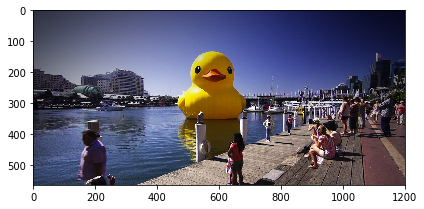

(564, 1200, 3)


In [2]:
# load the image and confirm skimage is imported properly.
image = io.imread('data/small_duck.jpg')
io.imshow(image)
io.show()
print(image.shape)

This single image has over 2 million values. Make sure your code is vectorized and efficient!

In [3]:
# save the dimensions of the image and reshape it for easier manipulation
rows = image.shape[0]
cols = image.shape[1]
image = image.reshape(image.shape[0]*image.shape[1],3)
print(image.shape)


(676800, 3)


## Random centroids (15 points)

Each centroid is a point in RGB space (color) in the image. This function should uniformly pick `k` centroids from the dataset.

Input: a single image of shape `(num_instances, 3)` and `k`, the number of centroids. Notice we are flattening the image to a two dimentional array.
Output: Randomly chosen centroids of shape `(k,3)`.

In [4]:
def get_random_centroids(X, k):
    centroids = np.zeros((k, 3))
    random_indexes = random.sample(range(X.shape[0]), k)
    for index in range(k):
        centroids[index] = X[random_indexes[index]]
    
    return centroids

In [5]:
k = 7 
centroids = get_random_centroids(image, k)
print(centroids.shape)

(7, 3)


## Distance function (25 points)

The Minkowski distance is a metric which can be considered as a generalization of the Euclidean and Manhattan distances. 

The Minkoski distance of order $p$ between two points: $\vec{x}=(x_1, ..., x_n)$ and $\vec{y}=(y_1, ..., y_n)$ is:
$$D(\vec{x},\vec{y}) = (\sum_{i=1}^n \mid x_i - y_i \mid ^p)^{\frac{1}{p}}$$

Implement the function `lp_distance` (=Minkoski distance).

Inputs: 
* a single image of shape `(num_instances, 3)` 
* the centroids `(k, 3)`
* the distance parameter p

output: array of shape `(k, num_instances)` thats holds the distances of all points in RGB space from all centroids

In [6]:
def lp_distance(X, centroids, p=2):
    distances = []
    for center in centroids:
        currentDistance = []
        for point in X:
            d = calcDistance(center,point,p)
            currentDistance.append(d)
        distances.append(currentDistance)   
    return np.array(distances)

def calcDistance(c,x,p):
    s = np.sum((np.absolute(x - c))**p)
    d = s ** (1/p)
    return d

In [7]:
%%time
distances = lp_distance(image, centroids, 5)
print(distances.shape)

(7, 676800)
Wall time: 30.8 s


## Kmeans algorithm (40 points)

Calculate the locally optimal centroids as learned in class. At each iteration, assign every RGB point to the closest centroids and calculate new centroids by averaging the points that were assigned to every centroid. This function stops, 
when no improvement was made or once max_iter iterations passed.

A reasonable implementation runs on a Core i7 CPU in less than a minute with `k=16`.

In [8]:
def kmeans(X, k, p ,max_iter=100):
    """
    Inputs:
    - X: a single image of shape (num_features, 3).
    - k: number of centroids.
    - p: the parameter governing the distance measure.
    - max_iter: the maximum number of iterations to perform.
    Outpust:
    - The calculated centroids
    - The final assignment of all RGB points to the closest centroids
    """
    classes = np.zeros(X.shape[0],dtype = int)
    thisCenter = []
    PrevCentroids = []
    iteration = 0
    similar = True
    
    centroids = get_random_centroids(X, k)
    get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
    
    while (iteration != 100 and similar):
        PrevCentroids = centroids
        distances = lp_distance(X, centroids, p)
        
        for col in range(distances.shape[1]):
            thisClass = np.argmin(distances[:,col])
            classes[col] = thisClass
            
        for center in range(k):
            thisCenter = get_indexes(center,classes)
            centroids[center] = createNewClaster(thisCenter, X)
            
        similar = not(np.array_equal(PrevCentroids,centroids))
        
        iteration = iteration + 1
        
    
    return centroids, classes

def createNewClaster(clasterIndexesToConcat, X):
    concat = []
    for i in clasterIndexesToConcat:
        concat.append(X[i])
    concat = np.array(concat)
    return np.average(concat,axis=0)

In [9]:
%%time
centroids, classes = kmeans(image, k=4, p=1, max_iter=100)

Wall time: 19.5 s


We obtained the locally optimal centroids (colors) from our image. To reconstruct the compressed image, we need to specify the color for each pixel that our algorithm associated with some centroid. The following cell does that for you.

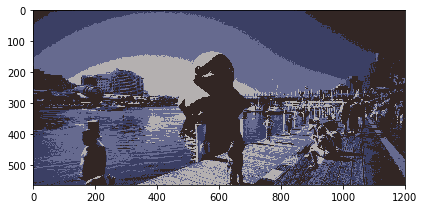

In [10]:
classes = classes.reshape(rows,cols) 
compressed_image = np.zeros((classes.shape[0],classes.shape[1],3),dtype=np.uint8 )
for i in range(classes.shape[0]):
    for j in range(classes.shape[1]):
            compressed_image[i,j,:] = centroids[classes[i,j],:]
io.imshow(compressed_image)
io.show()

## Hyper parameter tuning (20 points)

Pick 5 values for `p` and compare the results. Include both qualtitative and quantitivie analysis such as graphs, images and additional visualizations and explanations as you see fit.

p = 1


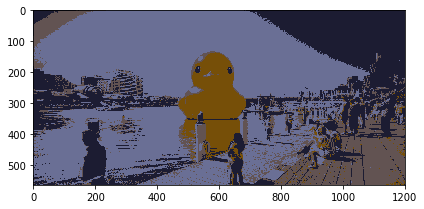

the number of instances in centroid [106.20600144 111.99093739 149.90501699] is: 344051
the number of instances in centroid [28.66026189 28.31337325 50.7607916 ] is: 182364
the number of instances in centroid [98.33205496 83.46688846 82.31201641] is: 104299
the number of instances in centroid [118.29115133  79.30926963   8.5769648 ] is: 46086


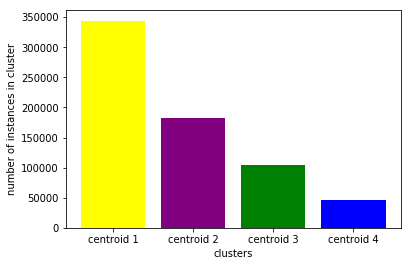



-------------------------------------------------------------------------------------------------------


p = 3


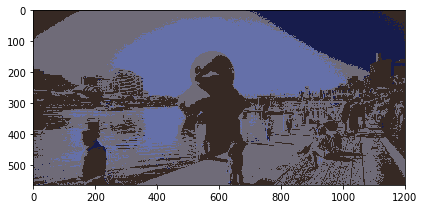

the number of instances in centroid [23.56876777 28.75647812 76.48178283] is: 61206
the number of instances in centroid [54.28518704 41.99447945 36.56561339] is: 193459
the number of instances in centroid [101.66752858 112.63327595 169.83830479] is: 145799
the number of instances in centroid [111.12142464 107.65298767 120.4870339 ] is: 276336


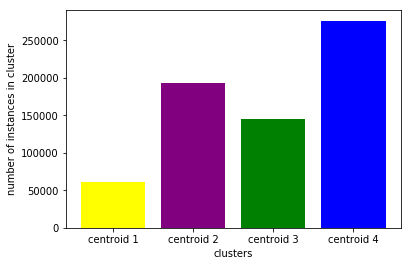



-------------------------------------------------------------------------------------------------------


p = 10


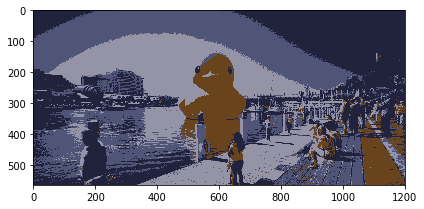

the number of instances in centroid [33.38265867 34.89913681 59.68478527] is: 224631
the number of instances in centroid [ 80.77055317  85.30951646 120.98812432] is: 213714
the number of instances in centroid [105.42082862  67.02299244  28.02061135] is: 67196
the number of instances in centroid [149.65605311 148.77788029 167.38080334] is: 171259


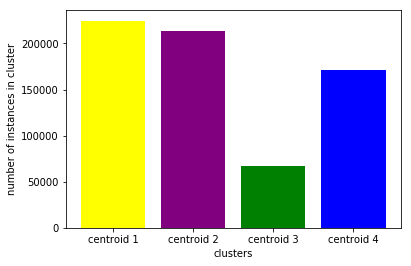



-------------------------------------------------------------------------------------------------------


p = 50


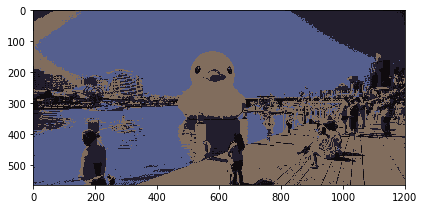

the number of instances in centroid [34.92020624 30.37382765 45.16972747] is: 122190
the number of instances in centroid [129.387211   109.81576272  93.42769333] is: 195715
the number of instances in centroid [15.28132894 11.75766159 14.86366072] is: 39189
the number of instances in centroid [ 85.34592407  95.05531019 142.08450576] is: 319706


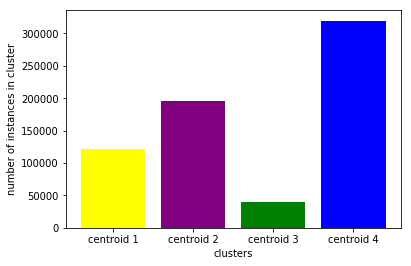



-------------------------------------------------------------------------------------------------------


p = 100


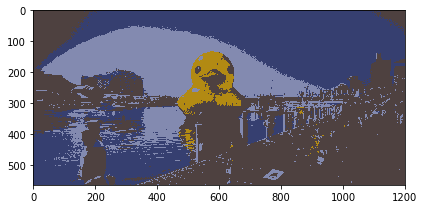

the number of instances in centroid [ 54.37391829  63.69374414 112.01862023] is: 223950
the number of instances in centroid [131.13976183 138.27802232 176.66485822] is: 146535
the number of instances in centroid [178.60552972 138.88103359  19.31958656] is: 19350
the number of instances in centroid [78.84153468 65.6538672  64.3432544 ] is: 286965


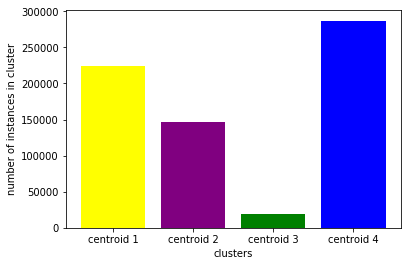



-------------------------------------------------------------------------------------------------------




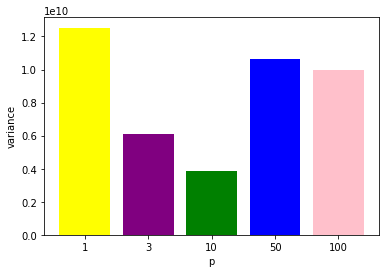

In [11]:
p_vals = [1, 3, 10, 50, 100]
vari = []

for p in p_vals:
    centroids, classes = kmeans(image, k=4, p=p, max_iter=100)
    classes = classes.reshape(rows,cols) 
    
    
    compressed_image = np.zeros((classes.shape[0],classes.shape[1],3),dtype=np.uint8 )
    for i in range(classes.shape[0]):
        for j in range(classes.shape[1]):
            compressed_image[i,j,:] = centroids[classes[i,j],:]
    print("p = " + str(p))
    io.imshow(compressed_image)
    io.show()
    
    
    index = 0
    for centroid in centroids:
        (classes == index).sum()
        print("the number of instances in centroid " + str(centroid) + " is: " +  str((classes == index).sum()))
        index += 1
        
    clusters_size =  [(classes == 0).sum(), (classes == 1).sum(), (classes == 2).sum(), (classes == 3).sum()]
    
    labels = ['centroid 1', 'centroid 2', 'centroid 3', 'centroid 4']
    vari.append(np.var(clusters_size))
    plt.bar(np.arange(4), clusters_size, color = ['yellow','purple', 'green', 'blue'])
    plt.xlabel('clusters')
    plt.ylabel('number of instances in cluster')
    plt.xticks(np.arange(4), labels)
    plt.show()
    

    print("\n")
    print("-------------------------------------------------------------------------------------------------------")
    print("\n")


    
ps = ['1', '3', '10', '50', '100']

plt.bar(np.arange(5), vari , color = ['yellow','purple', 'green', 'blue', 'pink'])
plt.xlabel('p')
plt.ylabel('variance')
plt.xticks(np.arange(5), ps)
plt.show()
    

we can see that for the lower p values the distribution of the instances in between classes is changing but we can see in the picture a presence Of different colors.
as p gorws most of the instances labeled in the same class.
for big p as 500 almost all of the instances lables has the same class and creating one big cluster, (we get an overflow error) and we can't see a clear picture, almost all of the instances classified to the same color - the one we see in the picture.